In [1]:
import time
import numpy as np
import tensorflow as tf
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_data_format("channels_last")

import matplotlib.pyplot as plt
from livelossplot import PlotLossesKeras
from PIL import Image

import pickle
import os
from keras.utils.data_utils import get_file

/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
# fixar random seed para se puder reproduzir os resultados
seed = 9
np.random.seed(seed)

In [3]:
def load_batch(fpath, label_key='labels'):
    f = open(fpath, 'rb')
    d = pickle.load(f, encoding='bytes')
    d_decoded = {}  # decode utf8
    for k, v in d.items():
        d_decoded[k.decode('utf8')] = v
    d = d_decoded
    f.close()
    data = d['data']
    labels = d[label_key]
    data = data.reshape(data.shape[0], 32, 32, 3)
    return data, labels


def load_cfar10_dataset():
    dirname = 'cifar-10-batches-py'
    origin = 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
    path = get_file(dirname, origin=origin, untar=True)
    num_train_samples = 50000
    x_train = np.zeros((num_train_samples, 32, 32, 3), dtype='uint8')
    y_train = np.zeros((num_train_samples,), dtype='uint8')
    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        data, labels = load_batch(fpath)
        x_train[(i - 1) * 10000: i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000: i * 10000] = labels
    fpath = os.path.join(path, 'test_batch')

    x_test, y_test = load_batch(fpath)
    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if K.image_data_format() == 'channels_last':
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)
    return (x_train, y_train), (x_test, y_test)


def visualize_cifar10():
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    #(X_train, y_train), (X_test, y_test) = load_cfar10_dataset()
    print(y_train)
    for i in range(0, 9):  # cria uma grelha com 3x3 imagens
        plt.subplot(330 + 1 + i)
        plt.imshow(Image.fromarray(X_train[i]))
    plt.show()


# util para visualizar a topologia da rede num ficheiro em pdf ou png
def print_model(model, fich):
    from keras.utils import plot_model
    plot_model(model, to_file=fich, show_shapes=True, show_layer_names=True)


# utils para visualização do historial de aprendizagem
def print_history_accuracy(history):
    print(history.history.keys())
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


def print_history_loss(history):
    print(history.history.keys())
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


def create_compile_model_cnn_cifar10_simples(num_classes, epochs):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3),
                     padding='same', activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (3, 3), activation='relu',
                     padding='same', kernel_constraint=maxnorm(3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile model
    lrate = 0.01
    decay = lrate/epochs
    sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd, metrics=['accuracy'])
    return model


def create_compile_model_cnn_cifar10_plus(num_classes, epochs):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3),
                     activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile model
    lrate = 0.01
    decay = lrate/epochs
    sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd, metrics=['accuracy'])
    return model


def cfar10_utilizando_cnn_simples():
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    #(X_train, y_train), (X_test, y_test) = load_cfar10_dataset()

    # normalize inputs from 0-255 to 0.0-1.0
    X_train = X_train.astype('float32')  # converter de inteiro para real
    X_test = X_test.astype('float32')
    X_train = X_train / 255.0
    X_test = X_test / 255.0

    # transformar o label que é um inteiro em categorias binárias, o valor passa a ser o correspondente à posição
    # a classe 5 passa a ser a lista [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    num_classes = y_test.shape[1]

    epochs = 10 # 5, 25
    model = create_compile_model_cnn_cifar10_simples(num_classes, epochs)
    #print(model.summary())
    print_model(model, "model_cifar10_cnn_simples.png")
    plotlosses = PlotLossesKeras()

    # treino do modelo: epochs=5, batch size = 32
    history = model.fit(X_train, y_train, validation_data=(
        X_test, y_test), epochs=epochs, batch_size=200, verbose=2, callbacks=[PlotLossesKeras()])

    # print_history_accuracy(history)
    # print_history_loss(history)

    # Avaliação final com os casos de teste
    scores = model.evaluate(X_test, y_test, verbose=0)
    #print('Scores: ', scores)
    print("Accuracy modelo CNN cifar10 simples: %.2f%%" % (scores[1]*100))
    print("Erro modelo CNN cifar10 simples: %.2f%%" % (100-scores[1]*100))


def cfar10_utilizando_cnn_plus():
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    #(X_train, y_train), (X_test, y_test) = load_cfar10_dataset()

    # normalize inputs from 0-255 to 0.0-1.0
    X_train = X_train.astype('float32')  # converter de inteiro para real
    X_test = X_test.astype('float32')
    X_train = X_train / 255.0
    X_test = X_test / 255.0

    # transformar o label que é um inteiro em categorias binárias, o valor passa a ser o correspondente à posição
    # a classe 5 passa a ser a lista [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    num_classes = y_test.shape[1]

    epochs = 10 # 5, 25
    model = create_compile_model_cnn_cifar10_plus(num_classes, epochs)
    #print(model.summary())
    print_model(model, "model_cifar10_cnn_plus.png")
    plotlosses = PlotLossesKeras()

    # treino do modelo: epochs=5, batch size = 64
    history = model.fit(X_train, y_train, validation_data=(
        X_test, y_test), epochs=epochs, batch_size=200, verbose=2, callbacks=[PlotLossesKeras()])

    #print_history_accuracy(history)
    #print_history_loss(history)

    # Avaliação final com os casos de teste
    scores = model.evaluate(X_test, y_test, verbose=0)
    #print('Scores: ', scores)
    print("Accuracy modelo CNN cifar10 plus: %.2f%%" % (scores[1]*100))
    print("Erro modelo CNN cifar10 plus: %.2f%%" % (100-scores[1]*100))

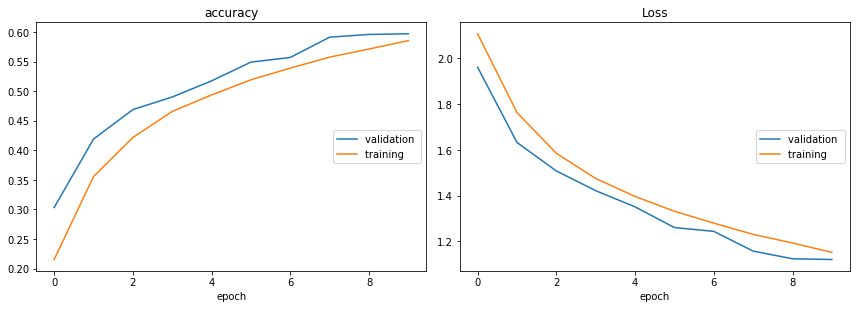

accuracy
	validation       	 (min:    0.303, max:    0.597, cur:    0.597)
	training         	 (min:    0.215, max:    0.586, cur:    0.586)
Loss
	validation       	 (min:    1.121, max:    1.961, cur:    1.121)
	training         	 (min:    1.152, max:    2.108, cur:    1.152)
Accuracy modelo CNN cifar10 plus: 59.71%
Erro modelo CNN cifar10 plus: 40.29%
Tempo processamento: 2786.663 segundos


In [4]:
if __name__ == '__main__':
    start_time = time.time()
    #visualize_cifar10()
    #cfar10_utilizando_cnn_simples()
    cfar10_utilizando_cnn_plus()
    time_taken = time.time() - start_time
    print("Tempo processamento: %.3f segundos" % (time_taken))

In [ ]:
def set_keras_backend(backend):
    print("A acertar o backend e libertar memória da gráfica")
    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        importlib.reload(K)
        assert K.backend() == backend
    if backend == "tensorflow":
        K.get_session().close()
        cfg = K.tensorflow_backend.tf.ConfigProto()
        cfg.gpu_options.allow_growth= True
        K.set_session(K.tensorflow_backend.tf.Session(config=cfg))
        
def limit_mem():
    K.get_session().close()
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))
    
set_keras_backend("tensorflow")
from tensorflow.python.client import device_lib
print("devices:", device_lib.list_local_devices())
visualize_cifar10()
with tf.device("/device:CPU:0"):
    start_time = time.time()
    cfar10_utilizando_cnn_simples()
    #cfar10_utilizando_cnn_plus()
    time_taken = time.time() - start_time
    print("Tempo processamento (cpu): %.3f segundos" % (time_taken))